# XRAY - RANDOM - CUSTOM 

## Installing and Importing Libraries

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

import tensorflow as tf
from pathlib import Path

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from sklearn.utils import class_weight 

1 Physical GPUs, 1 Logical GPUs


## Importing Dataset and Data Pre-Processing

In [2]:
data_dir = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY_RANDOM/"
train_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY_RANDOM/train/'
test_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY_RANDOM/test/'
img_width, img_height = 224, 224 
channels = 3
batch_size = 16
# image_arr_size= img_width * img_height * channels

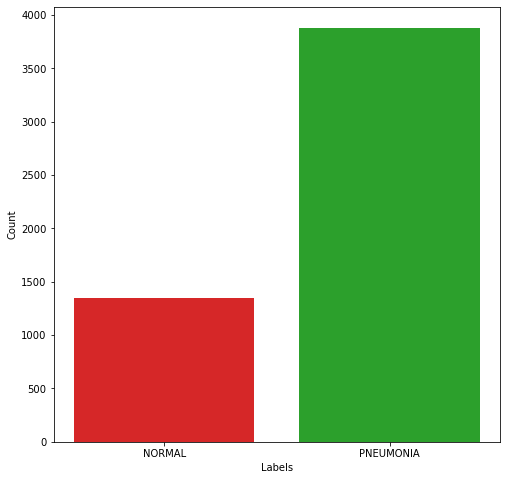

In [3]:
cnv_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
dme_images = len(glob(train_data_dir + 'PNEUMONIA/*.jpeg'))
data= {'NORMAL': cnv_images, 'PNEUMONIA': dme_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Sample Images from the Dataset

Normal


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  # Remove the CWD from sys.path while we load stuff.


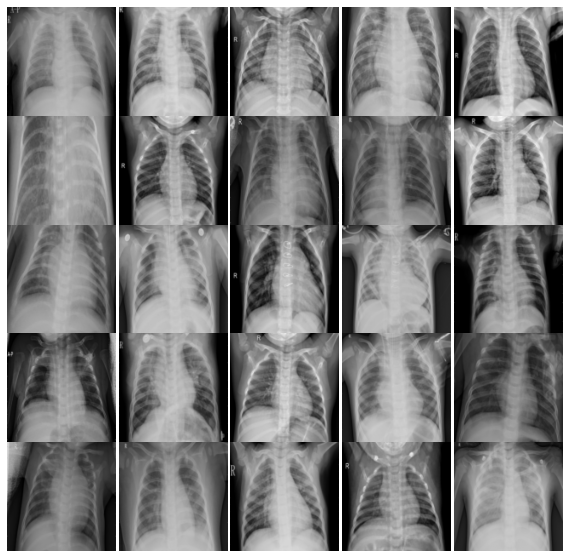

In [4]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  # Remove the CWD from sys.path while we load stuff.


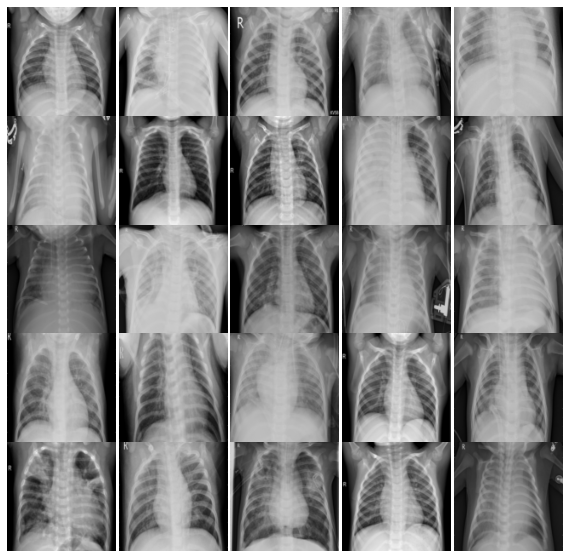

In [5]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/PNEUMONIA/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [6]:
train_datagen = ImageDataGenerator(
)

valid_test_datagen = ImageDataGenerator(
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 5231 images belonging to 2 classes.
Found 469 images belonging to 2 classes.


In [8]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_test_samples = len(test_generator.filenames)

# Model
* VGG16 CNN architecture is used for calssification.
* Pretrained on the 'ImageNet' dataset.

In [9]:
model = Sequential()
model.add(Conv2D(filters= 32 , kernel_size=(5,5), padding = 'same', activation = 'relu' , input_shape = (img_width, img_height,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

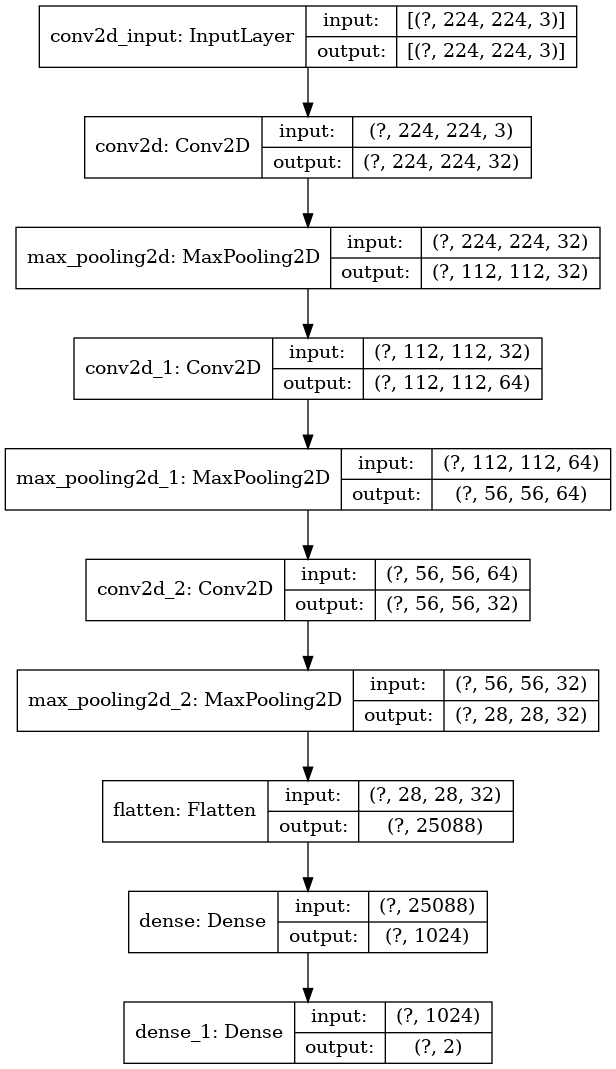

In [10]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Baseline Model Training

In [11]:
model.compile(optimizer= keras.optimizers.Adagrad(learning_rate=0.01), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [12]:
checkpoint = ModelCheckpoint(
    'basetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)


csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.75,
    patience=3,
    verbose=1, 
    mode='auto'
)

class_weights = class_weight.compute_class_weight(
       'balanced',
        np.unique(train_generator.classes), 
        train_generator.classes)
class_weights = dict(enumerate(class_weights))

callbacks = [checkpoint, csvlogger,reduceLR]

/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [13]:
history = model.fit(
    train_generator, 
    epochs = 100,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = test_generator,
    validation_steps = nb_test_samples//batch_size,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True,
    class_weight=class_weights
)

Epoch 1/100
326/326 [==============================] - ETA: 0s - loss: 1272.5879 - accuracy: 0.4888
Epoch 00001: loss improved from inf to 1272.58789, saving model to basetuned_model.h5
326/326 [==============================] - 48s 147ms/step - loss: 1272.5879 - accuracy: 0.4888 - val_loss: 0.7063 - val_accuracy: 0.4849 - lr: 0.0100
Epoch 2/100
326/326 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5266
Epoch 00002: loss improved from 1272.58789 to 0.69012, saving model to basetuned_model.h5
326/326 [==============================] - 46s 143ms/step - loss: 0.6901 - accuracy: 0.5266 - val_loss: 0.7135 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 3/100
326/326 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.5517
Epoch 00003: loss improved from 0.69012 to 0.68007, saving model to basetuned_model.h5
326/326 [==============================] - 44s 136ms/step - loss: 0.6801 - accuracy: 0.5517 - val_loss: 0.7226 - val_accuracy: 0.4914 - lr: 0.0100

Epoch 26/100
326/326 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.8780
Epoch 00026: loss improved from 0.29810 to 0.28325, saving model to basetuned_model.h5
326/326 [==============================] - 44s 136ms/step - loss: 0.2833 - accuracy: 0.8780 - val_loss: 1.3981 - val_accuracy: 0.5086 - lr: 0.0100
Epoch 27/100
326/326 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.8874
Epoch 00027: loss improved from 0.28325 to 0.26246, saving model to basetuned_model.h5
326/326 [==============================] - 44s 135ms/step - loss: 0.2625 - accuracy: 0.8874 - val_loss: 1.4357 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 28/100
326/326 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.8949
Epoch 00028: loss improved from 0.26246 to 0.24817, saving model to basetuned_model.h5
326/326 [==============================] - 44s 136ms/step - loss: 0.2482 - accuracy: 0.8949 - val_loss: 1.6348 - val_accuracy: 0.5129 - lr: 0.0100
Epoc

Epoch 51/100
326/326 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9854
Epoch 00051: loss improved from 0.05725 to 0.05408, saving model to basetuned_model.h5
326/326 [==============================] - 48s 147ms/step - loss: 0.0541 - accuracy: 0.9854 - val_loss: 3.4010 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 52/100
326/326 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9877
Epoch 00052: loss improved from 0.05408 to 0.05012, saving model to basetuned_model.h5
326/326 [==============================] - 48s 148ms/step - loss: 0.0501 - accuracy: 0.9877 - val_loss: 3.4370 - val_accuracy: 0.5237 - lr: 0.0100
Epoch 53/100
326/326 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9883
Epoch 00053: loss improved from 0.05012 to 0.04775, saving model to basetuned_model.h5
326/326 [==============================] - 48s 148ms/step - loss: 0.0477 - accuracy: 0.9883 - val_loss: 3.6990 - val_accuracy: 0.5323 - lr: 0.0100
Epoc

In [14]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

30/30 [==============================] - 4s 146ms/step - loss: 4.3929 - accuracy: 0.5437
Test Loss:  4.392910003662109
Test Accuracy:  0.5437099933624268


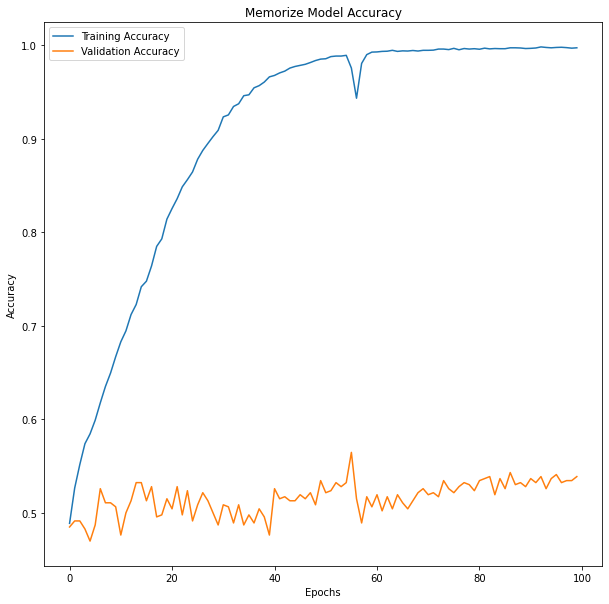

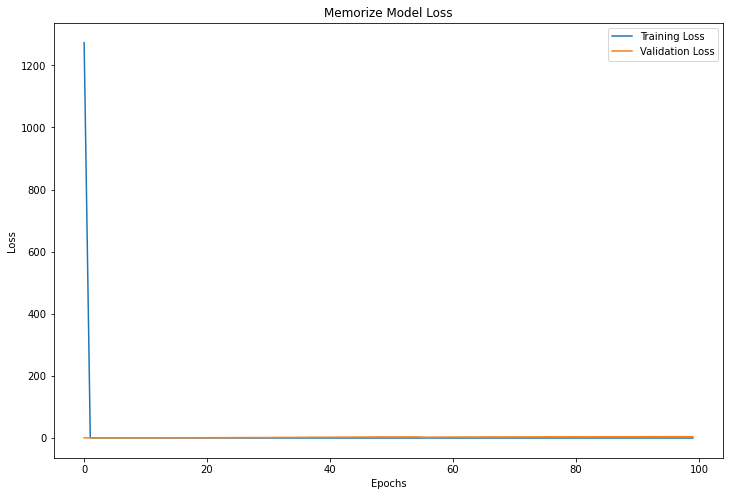

In [15]:
plt.subplot()
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.title('Memorize Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Memorize Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

## Reaching low loss with reduced dataset

In [16]:
model.trainable= True
model.compile(optimizer= keras.optimizers.Adagrad(), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [17]:
checkpoint = ModelCheckpoint(
    'finetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

csvlogger = CSVLogger(
    filename= "reduced_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.75,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [18]:
batch_size = 200

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 5231 images belonging to 2 classes.
Found 469 images belonging to 2 classes.


In [19]:
X, Y = train_generator.next()

In [20]:
class_weights = class_weight.compute_class_weight(
       'balanced',
        np.unique(np.argmax(Y, axis=1)), 
        np.argmax(Y, axis=1))
class_weights = dict(enumerate(class_weights))

/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [21]:
history_1 = model.fit(
    X, Y, 
    epochs = 100,
    batch_size= 16,
    validation_data = test_generator,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True,
    class_weight=class_weights
)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9800
Epoch 00001: loss improved from inf to 0.07212, saving model to finetuned_model.h5
13/13 [==============================] - 14s 1s/step - loss: 0.0721 - accuracy: 0.9800 - val_loss: 3.6484 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2857 - accuracy: 0.9010
Epoch 00002: loss did not improve from 0.07212
13/13 [==============================] - 22s 2s/step - loss: 0.2745 - accuracy: 0.9050 - val_loss: 3.8173 - val_accuracy: 0.5224 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9600
Epoch 00003: loss did not improve from 0.07212
13/13 [==============================] - 9s 712ms/step - loss: 0.1139 - accuracy: 0.9600 - val_loss: 3.8415 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9700
Epoch 00004: lo

13/13 [==============================] - 8s 624ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 4.6280 - val_accuracy: 0.5224 - lr: 0.0010
Epoch 27/100
13/13 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000
Epoch 00027: loss improved from 0.00343 to 0.00338, saving model to finetuned_model.h5
13/13 [==============================] - 8s 610ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 4.6402 - val_accuracy: 0.5203 - lr: 0.0010
Epoch 28/100
13/13 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 00028: loss improved from 0.00338 to 0.00331, saving model to finetuned_model.h5
13/13 [==============================] - 8s 621ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.6412 - val_accuracy: 0.5224 - lr: 0.0010
Epoch 29/100
13/13 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
Epoch 00029: loss improved from 0.00331 to 0.00314, saving model to finetuned_model.h5
13/13 [============

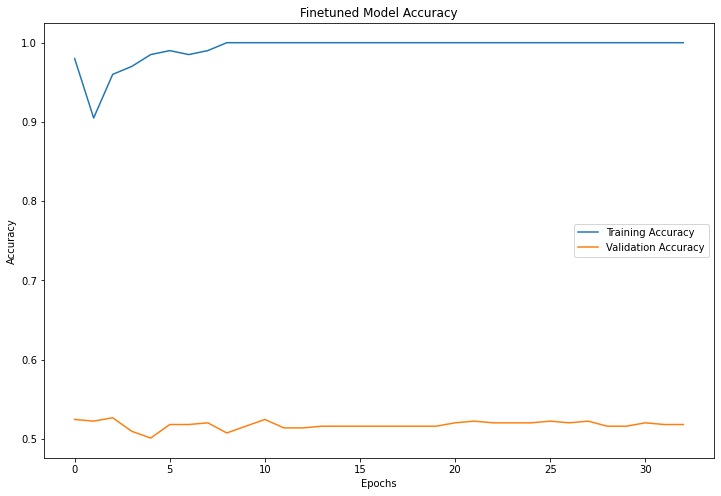

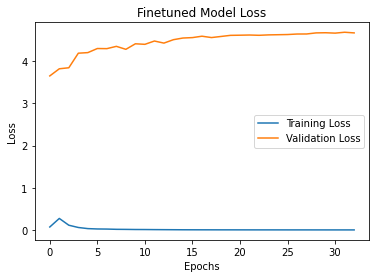

In [22]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

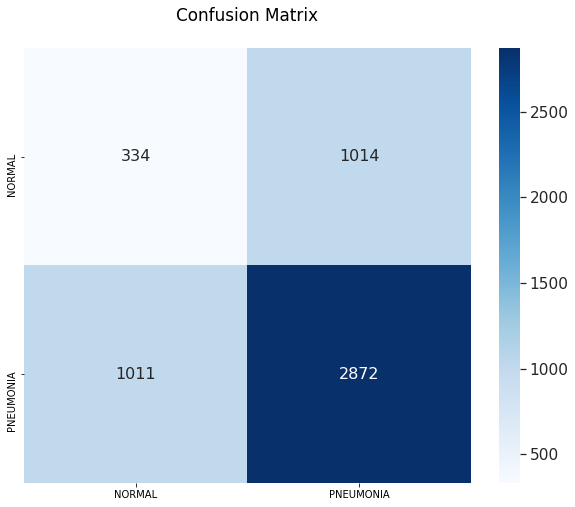

Classification Report

              precision    recall  f1-score   support

      NORMAL       0.25      0.25      0.25      1348
   PNEUMONIA       0.74      0.74      0.74      3883

    accuracy                           0.61      5231
   macro avg       0.49      0.49      0.49      5231
weighted avg       0.61      0.61      0.61      5231



In [23]:
Y_pred = model.predict(train_generator, nb_train_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(train_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(train_generator.class_indices.keys()), list(train_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix_train.png', transparent= False, bbox_inches= 'tight', dpi= 400)

plt.show()

print('Classification Report\n')
target_names = list(train_generator.class_indices.keys())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

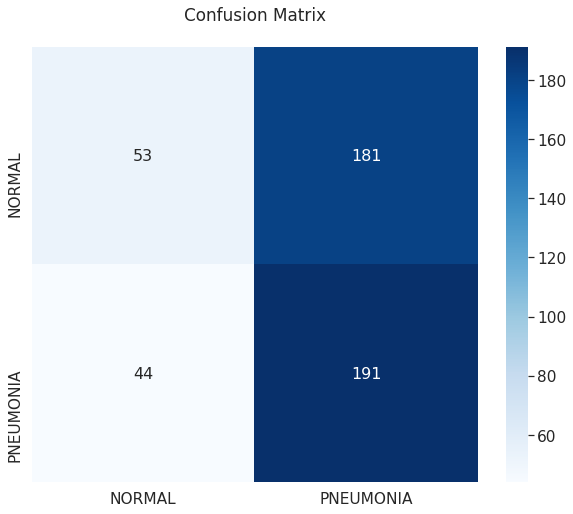

Classification Report

              precision    recall  f1-score   support

      NORMAL       0.55      0.23      0.32       234
   PNEUMONIA       0.51      0.81      0.63       235

    accuracy                           0.52       469
   macro avg       0.53      0.52      0.47       469
weighted avg       0.53      0.52      0.48       469



In [24]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))